In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import bt_mle_utils as mle
from simulation_utils import *

## Banded

In [2]:
def get_k_banded_adj(n, k, permute = False):
    # k-cayley graph
    adj = np.zeros((n,n))
    for i in range(n):
        for j in range(1, k + 1):
            col = (i + j)
            if col < n:
                adj[i, col] = 1
            
            col = (i - j)
            if col > -1:
                adj[i, col] = 1
    if permute:
        P = np.zeros((n,n))
        P[np.arange(n), np.random.permutation(n)] = 1
        adj = P.T @ adj @ P
    return adj

In [3]:
A = get_k_banded_adj(n = 10, k = 2)
A

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]])

In [4]:
def get_bound_our(kappa, lam2, n_max, n_min, n, L, no_kappa = False):
    if no_kappa:
        return 1/lam2 * (n_max/n_min) * np.sqrt(n / L) + 1/lam2 * np.sqrt(n_max * np.log(n) / L)
    else:
        return np.exp(2 * kappa)/lam2 * (n_max/n_min) * np.sqrt(n / L) + np.exp(kappa)/lam2 * np.sqrt(n_max * np.log(n) / L)


def get_bound_our_l2(kappa, lam2, n_max, n_min, n, L, no_kappa = False):
    if no_kappa:
        return 1/lam2 * np.sqrt(n * n_max / L)
    else:
        return np.exp(kappa)/lam2 * np.sqrt(n * n_max / L)

In [5]:
import time

In [6]:
n_list = np.array([25, 50, 75, 100, 200, 300, 400, 600, 800, 1000])
m = len(n_list)

k_list = (n_list / np.log(n_list)).astype(int)
B = 20

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_our_e_list = np.zeros(m)

bound_our_l2_list = np.zeros(m)
bound_our_e_l2_list = np.zeros(m)
ratio_list = np.zeros(m)

bound_yan_mat = np.zeros((m,B))
bound_shah_mat = np.zeros((m,B))
bound_our_mat = np.zeros((m,B))
bound_our_e_mat = np.zeros((m,B))
bound_our_l2_mat = np.zeros((m,B))
bound_our_e_l2_mat = np.zeros((m,B))
ratio_mat = np.zeros((m,B))


l_infty_beta_list = np.zeros(m)
l_infty_beta_mat = np.zeros((m,B))
l2_beta_list = np.zeros(m)
l2_beta_mat = np.zeros((m,B))

np.random.seed(0)

for ix, n in enumerate(n_list):
    st = time.time()
    # delta = np.log(n) / n
    k = k_list[ix]
    kappa = np.sqrt(np.log(n))
    delta = 1
    beta = get_beta_with_gap(n, delta)
    beta *= kappa / (np.max(beta) - np.min(beta))
    total = 10
    
    lam, n_ij = 0, 0
    
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_our_e_ = np.zeros(B)
    bound_our_l2_, bound_our_e_l2_ = np.zeros(B), np.zeros(B)
    ratio_ = np.zeros(B)
    
    l_infty_beta_, l2_beta_ = np.zeros(B), np.zeros(B)
  
    for b in range(B):
        A = get_k_banded_adj(n = n, k = k)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b] = np.max(np.abs(beta-beta_hat))
        l2_beta_[b] = np.sum((beta-beta_hat)**2)**0.5
        
        L = total
        bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        bound_our_l2_[b] = get_bound_our_l2(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        kappa_E = kappa * k / n
        bound_our_e_[b] = get_bound_our(kappa_E, lam2_[b], n_max_[b], n_min_[b], n, L)
        bound_our_e_l2_[b] = get_bound_our_l2(kappa_E, lam2_[b], n_max_[b], n_min_[b], n, L)
        
        
        ratio_[b] = bound_our_[b] / bound_yan_[b]
        
        bound_yan_mat[ix,b] = (bound_yan_[b])
        bound_shah_mat[ix,b] = (bound_shah_[b])
        bound_our_mat[ix,b] = (bound_our_[b])
        bound_our_l2_mat[ix,b] = (bound_our_l2_[b])
        bound_our_e_mat[ix,b] = (bound_our_e_[b])
        bound_our_e_l2_mat[ix,b] = (bound_our_e_l2_[b])
        ratio_mat[ix,b] = (ratio_[b])
        
        l_infty_beta_mat[ix, b] = l_infty_beta_[b]
        l2_beta_mat[ix, b] = l2_beta_[b]
    
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    l2_beta_list[ix] = np.mean(l2_beta_)
    
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
    bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_our_e_list[ix] = np.mean(bound_our_e_)
    bound_our_l2_list[ix] = np.mean(bound_our_l2_)
    bound_our_e_l2_list[ix] = np.mean(bound_our_e_l2_)
    
    ratio_list[ix] = np.mean(ratio_)
    
    print(n)
    print('time: ', str(time.time() - st))

E:\python_notebook\ranking\bradley-terry\uai2022\simulation_utils.py:153: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(kappa) / n_ij * np.sqrt(L * n * np.log(n + 1))


25
time:  0.23909711837768555
50
time:  0.878331184387207
75
time:  1.7253444194793701
100
time:  3.449275493621826
200
time:  12.648170232772827
300
time:  28.565519332885742
400
time:  73.4922776222229
600
time:  145.85959124565125
800
time:  145.8357150554657
1000
time:  273.27931547164917


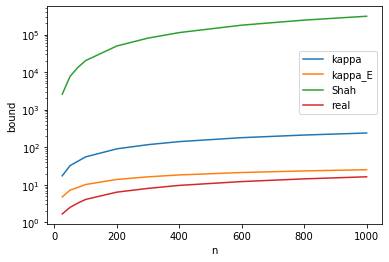

In [7]:
plt.plot(n_list, bound_our_l2_list)
plt.plot(n_list, bound_our_e_l2_list)
plt.plot(n_list, bound_shah_list)
plt.plot(n_list, l2_beta_list)
plt.xlabel('n')
plt.ylabel('bound')
plt.yscale('log')
plt.legend(['kappa','kappa_E','Shah','real'], loc = 'center right', bbox_to_anchor=(0.5, 0.4, 0.5, 0.5))
plt.savefig("banded_compare.pdf", bbox_inches = 'tight')

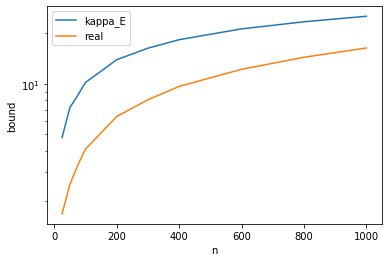

In [8]:
plt.plot(n_list, bound_our_e_l2_list)
plt.plot(n_list, l2_beta_list)
plt.xlabel('n')
plt.ylabel('bound')
plt.yscale('log')
plt.legend(['kappa_E','real'])

In [9]:
n_list = np.array([25, 50, 75, 100, 200, 300, 400, 600, 800, 1000])
m = len(n_list)

k_list = (n_list**0.5).astype(int)
B = 20

lam2_list = np.zeros(m)
min_n_ij_list = np.zeros(m)
n_max_list = np.zeros(m)
n_min_list = np.zeros(m)

bound_yan_list = np.zeros(m)
bound_shah_list = np.zeros(m)
bound_our_list = np.zeros(m)
bound_our_e_list = np.zeros(m)

bound_our_l2_list = np.zeros(m)
bound_our_e_l2_list = np.zeros(m)
ratio_list = np.zeros(m)

bound_yan_mat = np.zeros((m,B))
bound_shah_mat = np.zeros((m,B))
bound_our_mat = np.zeros((m,B))
bound_our_e_mat = np.zeros((m,B))
bound_our_l2_mat = np.zeros((m,B))
bound_our_e_l2_mat = np.zeros((m,B))
ratio_mat = np.zeros((m,B))


l_infty_beta_list = np.zeros(m)
l_infty_beta_mat = np.zeros((m,B))
l2_beta_list = np.zeros(m)
l2_beta_mat = np.zeros((m,B))

np.random.seed(0)

for ix, n in enumerate(n_list):
    st = time.time()
    # delta = np.log(n) / n
    k = k_list[ix]
    kappa = np.sqrt(np.log(n))
    delta = 1
    beta = get_beta_with_gap(n, delta)
    beta *= kappa / (np.max(beta) - np.min(beta))
    total = 10
    
    lam, n_ij = 0, 0
    
    lam2_, n_ij_, n_max_, n_min_ = np.zeros(B), np.zeros(B), np.zeros(B), np.zeros(B)
    bound_yan_, bound_shah_, bound_our_ = np.zeros(B), np.zeros(B), np.zeros(B)
    bound_our_e_ = np.zeros(B)
    bound_our_l2_, bound_our_e_l2_ = np.zeros(B), np.zeros(B)
    ratio_ = np.zeros(B)
    
    l_infty_beta_, l2_beta_ = np.zeros(B), np.zeros(B)
  
    for b in range(B):
        A = get_k_banded_adj(n = n, k = k)
        lam2_[b], n_ij_[b], n_max_[b], n_min_[b] = get_topo(A)
        
        edge_list = get_edge(A)
        game_matrix = get_game_matrix(beta, edge_list, total)
        
        beta_hat = get_mle_reg(game_matrix)
        l_infty_beta_[b] = np.max(np.abs(beta-beta_hat))
        l2_beta_[b] = np.sum((beta-beta_hat)**2)**0.5
        
        L = total
        bound_yan_[b] = get_bound_yan(kappa, n_ij_[b], n, L = total)
        bound_shah_[b] = get_bound_shah(kappa, lam2_[b], n, L = total)
        bound_our_[b] = get_bound_our(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        bound_our_l2_[b] = get_bound_our_l2(kappa, lam2_[b], n_max_[b], n_min_[b], n, L)
        kappa_E = kappa * k / n
        bound_our_e_[b] = get_bound_our(kappa_E, lam2_[b], n_max_[b], n_min_[b], n, L)
        bound_our_e_l2_[b] = get_bound_our_l2(kappa_E, lam2_[b], n_max_[b], n_min_[b], n, L)
        
        
        ratio_[b] = bound_our_[b] / bound_yan_[b]
        
        bound_yan_mat[ix,b] = (bound_yan_[b])
        bound_shah_mat[ix,b] = (bound_shah_[b])
        bound_our_mat[ix,b] = (bound_our_[b])
        bound_our_l2_mat[ix,b] = (bound_our_l2_[b])
        bound_our_e_mat[ix,b] = (bound_our_e_[b])
        bound_our_e_l2_mat[ix,b] = (bound_our_e_l2_[b])
        ratio_mat[ix,b] = (ratio_[b])
        
        l_infty_beta_mat[ix, b] = l_infty_beta_[b]
        l2_beta_mat[ix, b] = l2_beta_[b]
    
    l_infty_beta_list[ix] = np.mean(l_infty_beta_)
    l2_beta_list[ix] = np.mean(l2_beta_)
    
    lam2_list[ix] = np.mean(lam2_)
    min_n_ij_list[ix] = np.mean(n_ij_)
    n_max_list[ix], n_min_list[ix] = np.mean(n_max_), np.mean(n_min_)
    bound_yan_list[ix] = np.mean(bound_yan_)
    bound_shah_list[ix] = np.mean(bound_shah_)
    bound_our_list[ix] = np.mean(bound_our_)
    bound_our_e_list[ix] = np.mean(bound_our_e_)
    bound_our_l2_list[ix] = np.mean(bound_our_l2_)
    bound_our_e_l2_list[ix] = np.mean(bound_our_e_l2_)
    
    ratio_list[ix] = np.mean(ratio_)
    
    print(n)
    print('time: ', str(time.time() - st))

E:\python_notebook\ranking\bradley-terry\uai2022\simulation_utils.py:153: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(kappa) / n_ij * np.sqrt(L * n * np.log(n + 1))


25
time:  0.642359733581543
50
time:  2.6705498695373535
75
time:  7.8171000480651855
100
time:  15.285581111907959
200
time:  124.21519899368286
300
time:  463.6923360824585
400
time:  1427.1262485980988
600
time:  146.94993567466736
800
time:  244.75491952896118
1000
time:  359.9209611415863


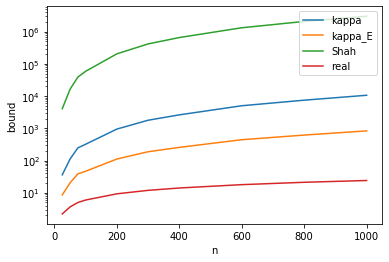

In [10]:
plt.plot(n_list, bound_our_l2_list)
plt.plot(n_list, bound_our_e_l2_list)
plt.plot(n_list, bound_shah_list)
plt.plot(n_list, l2_beta_list)
plt.xlabel('n')
plt.ylabel('bound')
plt.yscale('log')
plt.legend(['kappa','kappa_E','Shah','real'])
plt.savefig("banded_compare_sqrt.pdf", bbox_inches = 'tight')

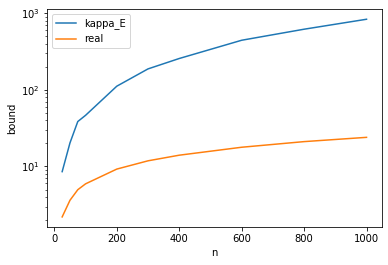

In [11]:
plt.plot(n_list, bound_our_e_l2_list)
plt.plot(n_list, l2_beta_list)
plt.xlabel('n')
plt.ylabel('bound')
plt.yscale('log')
plt.legend(['kappa_E','real'])